In [1]:
import torch
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

from uncertaintylearning.utils import (FixedKernelDensityEstimator, CVKernelDensityEstimator,
                                       create_network, create_optimizer, create_multiplicative_scheduler)
from uncertaintylearning.models import EpistemicPredictor
from torch.utils.data import DataLoader, TensorDataset


import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [1]:
noise = .1


def f(X, noise=noise):
    return torch.sin(X) * torch.cos(5 * X) * torch.cos(22 * X) + noise * torch.randn_like(X)


bounds = (-1, 2)
# f, bounds = repeat(f, bounds)
# f, bounds = repeat(f, bounds)

X_init = (bounds[1] - bounds[0]) * torch.rand(6, 1) + bounds[0]
Y_init = f(X_init)

X = torch.arange(bounds[0], bounds[1], 0.01).reshape(-1, 1)
Y = f(X, 0)

def augment(X, Y, n=20, epsilon=.01):
    new_X = X.repeat(1 + n, 1)
    new_Y = Y.repeat(1 + n, 1)
    for i in range(1, n+1):
        new_X[i * len(X): i * len(X) + len(X)]  += epsilon * torch.randn((len(X), X.size(1)))
    return new_X, new_Y
        
# X_init, Y_init = augment(X_init, Y_init)
    


# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

NameError: name 'torch' is not defined

In [3]:
def optimize(model_name, X_init, Y_init, plot=False, n_steps=5, **kwargs):

    full_train_X = X_init
    full_train_Y = Y_init
    
    f_losses = []
    e_losses = []
    a_losses = []
    state_dict = None
    max_value_per_step = [full_train_Y.max().item()]

    full_train_Y_2 = None
    # full_train_Y_2 = f(full_train_X)
    for step in range(n_steps):
        # print(step)
        if model_name == EpistemicPredictor:
            density_estimator = FixedKernelDensityEstimator('exponential', 0.05)
            model = model_name(full_train_X, full_train_Y, train_Y_2=full_train_Y_2, density_estimator=density_estimator, **kwargs)

            for _ in range(15):
                losses = model.fit()
                f_losses.append(np.mean(losses['f']))
                a_losses.append(np.mean(losses['a']))
                e_losses.append(np.mean(losses['e']))
        elif model_name == SingleTaskGP:
            model = model_name(full_train_X, full_train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            if state_dict is not None:
                model.load_state_dict(state_dict)
            fit_gpytorch_model(mll)
        else:
            raise Exception('Not sure this would work !')

        EI = ExpectedImprovement(model, full_train_Y.max().item())
        eis = EI(X.unsqueeze(1)).detach()
        max_ei, argmax_ei = torch.max(eis, 0)
        xmax = X[argmax_ei].item()
        max_ei = max_ei.item()

        bounds_t = torch.FloatTensor([[bounds[0]], [bounds[1]]])
        candidate, acq_value = optimize_acqf(
            EI, bounds=bounds_t, q=1, num_restarts=5, raw_samples=50,
        )

        if plot:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))
            # Plot optimization objective with noise level
            ax1.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
            ax1.plot(X, f(X), 'rx', lw=1, alpha=0.2, label='Noisy samples')
            ax1.plot(full_train_X, full_train_Y, 'kx', mew=3, label='Used for training')

            ax1.plot(X, model(X).mean.detach().squeeze(), label='mean pred')
            ax1.fill_between(X.numpy().ravel(),
                             model(X).mean.detach().numpy().ravel() - model(X).stddev.detach().numpy().ravel(),
                             model(X).mean.detach().numpy().ravel() + model(X).stddev.detach().numpy().ravel(),
                             alpha=.4)

            # if isinstance(model, EpistemicPredictor):
            #     ax1.plot(X, model.density_estimator.score_samples(X), 'r-', label='density')
                
            ax1.set_ylim(-3, 2)

            ax2.plot(X, eis, 'r-', label='EI')
            ax2.plot(X, [max_ei] * len(X), 'b--')
            ax2.plot([xmax] * 100, torch.linspace(0, max_ei, 100), 'b--')
            ax1.legend()
            ax2.legend()
            
            ax3.plot(f_losses, label='f')
            ax3.plot(e_losses, label='e')
            ax3.plot(a_losses, label='a')
            ax3.set_ylim(0, 10)
            ax3.legend()
            plt.show()
            
        full_train_X = torch.cat([full_train_X, candidate])
        full_train_Y = torch.cat([full_train_Y, f(candidate)])
        if model_name == EpistemicPredictor and full_train_Y_2 is not None:
            full_train_Y_2 = torch.cat([full_train_Y_2, f(candidate)])

        max_value_per_step.append(full_train_Y.max().item())

    return max_value_per_step, f_losses

In [ ]:
# SETTING THESE 3 SEEDS ENSURES DETERMINISTIC RESULTS
# GP IS DETERMINISTIC given X_init and Y_init

# density_estimator = FixedKernelDensityEstimator('exponential', 0.05)
torch.manual_seed(8)
networks = {'a_predictor': create_network(1, 1, 64, 'tanh', True),
            'e_predictor': create_network(2, 1, 64, 'relu', True),
            'f_predictor': create_network(1, 1, 64, 'relu', False)
            }

optimizers = {'a_optimizer': create_optimizer(networks['a_predictor'], 1e-3),
              'e_optimizer': create_optimizer(networks['e_predictor'], 1e-4),
              'f_optimizer': create_optimizer(networks['f_predictor'], 1e-3)
              }

X_init = (bounds[1] - bounds[0]) * torch.rand(6, 1) + bounds[0]
Y_init = f(X_init)

#optimize(EpistemicPredictor, X_init, Y_init, plot=True, n_steps=25,  networks=networks, optimizers=optimizers,
#         split_seed=1, dataloader_seed=2)
optimize(SingleTaskGP, X_init, Y_init, plot=True, n_steps=25)

In [ ]:
import numpy as np
n_runs = 3
n_steps = 25
gp_runs = np.zeros((n_runs, n_steps + 1))
ep_runs = np.zeros((n_runs, n_steps + 1))

for i in range(0, n_runs):
    torch.manual_seed(i)
    X_init = (bounds[1] - bounds[0]) * torch.rand(6, 1) + bounds[0]
    Y_init = f(X_init)
    
    networks = {'a_predictor': create_network(1, 1, 64, 'tanh', True),
                'e_predictor': create_network(2, 1, 64, 'relu', True),
                'f_predictor': create_network(1, 1, 64, 'relu', False)
                }

    optimizers = {'a_optimizer': create_optimizer(networks['a_predictor'], 1e-3),
                  'e_optimizer': create_optimizer(networks['e_predictor'], 1e-4),
                  'f_optimizer': create_optimizer(networks['f_predictor'], 1e-3)
                  }
    
    print(f"Run {i+1}/{n_runs}")
    gp_runs[i], _ = optimize(SingleTaskGP, X_init, Y_init, plot=False, n_steps=n_steps)
    density_estimator = FixedKernelDensityEstimator('exponential', 0.1)

    ep_runs[i], _ = optimize(EpistemicPredictor, X_init, Y_init, plot=False, n_steps=n_steps, networks=networks, optimizers=optimizers)
    plt.errorbar(range(1 + n_steps), gp_runs[:i+1].mean(0),  .2*gp_runs[:i+1].std(0), label='Average maximum value reached by GP')
    plt.errorbar(range(1 + n_steps), ep_runs[:i+1].mean(0),  .2*ep_runs[:i+1].std(0), label='Average maximum value reached by EP')


    plt.legend()
    plt.title('ERROR BARS ARE ONLY 0.3 * STD !! ')
    plt.show()

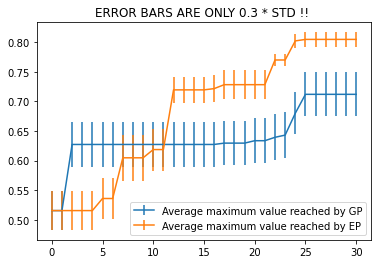